In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [2]:
class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch : np.random.normal(mu,sigma, (n_batch,ni_D))
        self.in_sample = lambda n_batch : np.random.rand(n_batch, ni_D)

In [3]:
class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 1
        self.n_iter_G = 5

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)

        self.n_batch = n_batch
        # self.ni_D = ni_D

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        # Real data
        Real = data.real_sample(n_batch)  # (n_batch, ni_D)
        # print(Real.shape)
        # Generated data
        Z = data.in_sample(n_batch)  # (n_batch, ni_D)
        Gen = gan.G.predict(Z)  # (n_batch, ni_D)
        # print(Gen.shape)

        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data for data generation
        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        gan.GD_train_on_batch(Z)

    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()

    def test(self, n_test):
        """
        generate a new image
        """
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        """
        train GAN and show the results
        for showing, the original and the artificial results will be compared
        """
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))


In [4]:
def add_decorate(x):
    """
    axis = -1 --> last dimension in an array
    """
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)


def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

In [5]:
lr = 2e-4
adam = Adam(lr=lr, beta_1 = 0.9, beta_2 = 0.999)

In [6]:
def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [7]:
class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G

        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))

        model_compile(D)
        return D

    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_D

        G = models.Sequential()  # (Batch, ni_D)
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))  # (Batch, steps=ni_D, input_dim=1)
        G.add(Conv1D(nh_G, 1, activation='relu'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(1, 1))  # (Batch, ni_D, 1)
        G.add(Flatten())  # (Batch, ni_D)

        model_compile(G)
        return G

    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD

    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)


Stage 0 (Epoch: 0)
Mean and Std of Real: (4.008509425364452, 1.2514202979303402)
Mean and Std of Gen: (1.5983675, 0.84993917)


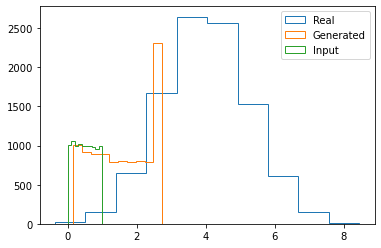

Stage 1 (Epoch: 200)
Mean and Std of Real: (4.00422598343299, 1.2474195790049372)
Mean and Std of Gen: (3.5807507, 1.2021072)


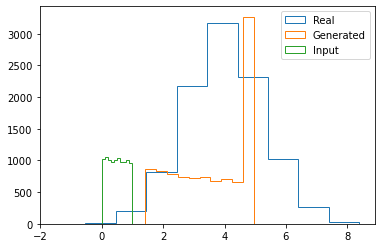

Stage 2 (Epoch: 400)
Mean and Std of Real: (3.9927348390395476, 1.2419749925013208)
Mean and Std of Gen: (4.6253877, 0.84518874)


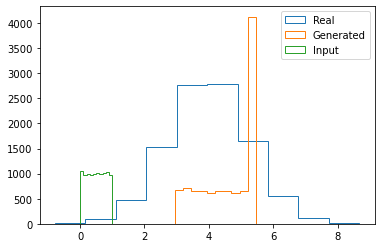

Stage 3 (Epoch: 600)
Mean and Std of Real: (3.9977789406630997, 1.231501600724853)
Mean and Std of Gen: (3.5411105, 1.3128376)


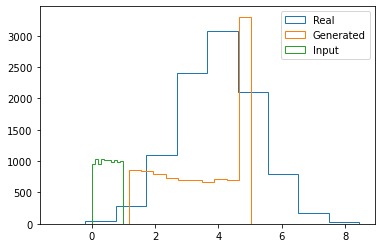

Stage 4 (Epoch: 800)
Mean and Std of Real: (3.9892281667195535, 1.2393489840310916)
Mean and Std of Gen: (3.006319, 1.3261524)


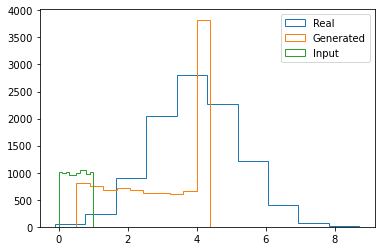

Stage 5 (Epoch: 1000)
Mean and Std of Real: (3.9974438051278494, 1.2346855956376859)
Mean and Std of Gen: (3.833816, 1.2182693)


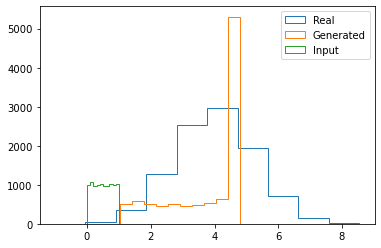

Stage 6 (Epoch: 1200)
Mean and Std of Real: (4.00539407727547, 1.245347954495422)
Mean and Std of Gen: (4.300901, 1.3324162)


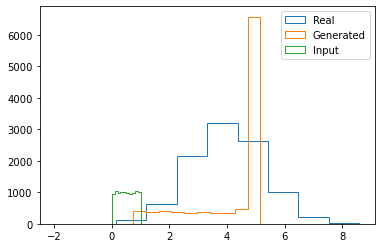

Stage 7 (Epoch: 1400)
Mean and Std of Real: (3.999213649308034, 1.2531699274379708)
Mean and Std of Gen: (4.9916677, 1.4735532)


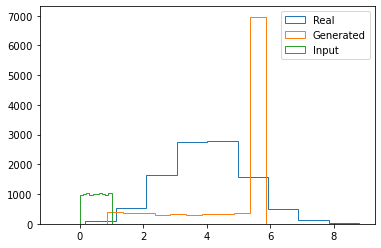

Stage 8 (Epoch: 1600)
Mean and Std of Real: (4.024270410111964, 1.2366182821230005)
Mean and Std of Gen: (5.22884, 1.3294097)


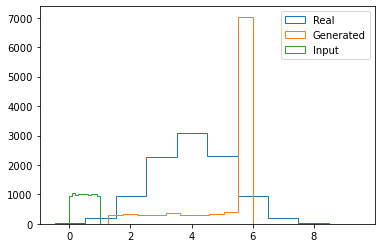

Stage 9 (Epoch: 1800)
Mean and Std of Real: (4.009122409764813, 1.2506259885587805)
Mean and Std of Gen: (5.421066, 1.4351379)


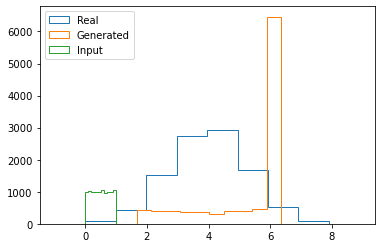

Stage 10 (Epoch: 2000)
Mean and Std of Real: (4.005539224884851, 1.2429968035005636)
Mean and Std of Gen: (5.017128, 1.3332342)


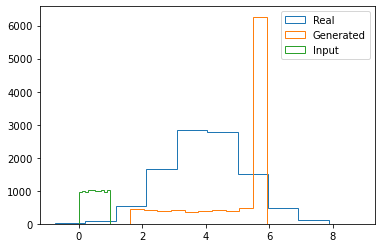

Stage 11 (Epoch: 2200)
Mean and Std of Real: (4.009122939469472, 1.2596395661306985)
Mean and Std of Gen: (4.593107, 1.3295105)


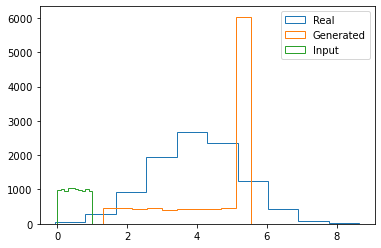

Stage 12 (Epoch: 2400)
Mean and Std of Real: (4.019612551452655, 1.2489340728166587)
Mean and Std of Gen: (4.140822, 1.2851486)


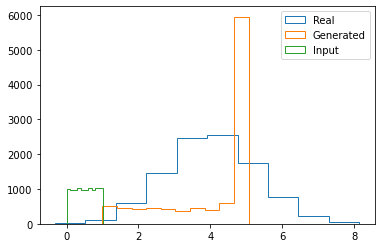

Stage 13 (Epoch: 2600)
Mean and Std of Real: (4.010892626699502, 1.253095509024565)
Mean and Std of Gen: (4.1407204, 1.2895674)


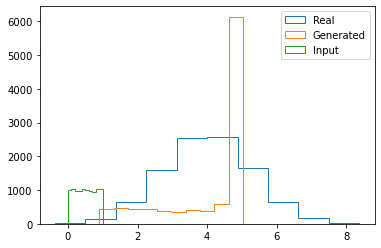

Stage 14 (Epoch: 2800)
Mean and Std of Real: (3.974357759788401, 1.2536158897967702)
Mean and Std of Gen: (4.3017006, 1.2394736)


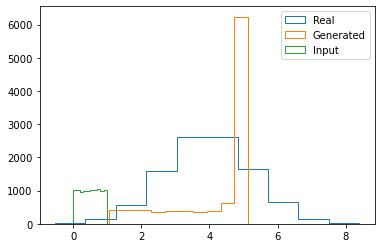

Stage 15 (Epoch: 3000)
Mean and Std of Real: (3.993229448490274, 1.24915757067371)
Mean and Std of Gen: (3.8973026, 1.2594296)


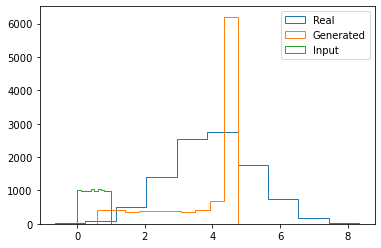

Stage 16 (Epoch: 3200)
Mean and Std of Real: (3.9938782698584903, 1.253485048783141)
Mean and Std of Gen: (4.068247, 1.2381929)


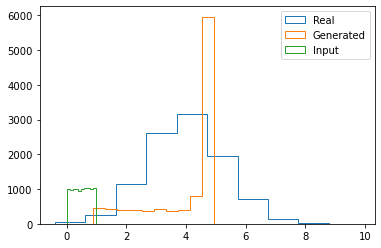

Stage 17 (Epoch: 3400)
Mean and Std of Real: (3.9844436096355826, 1.225508947413774)
Mean and Std of Gen: (4.050263, 1.2904336)


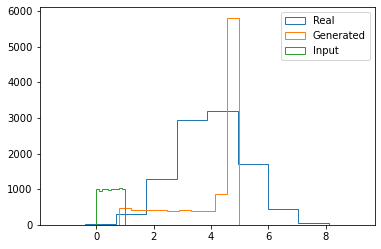

Stage 18 (Epoch: 3600)
Mean and Std of Real: (4.02153957204366, 1.2544077697425318)
Mean and Std of Gen: (4.0879893, 1.3351109)


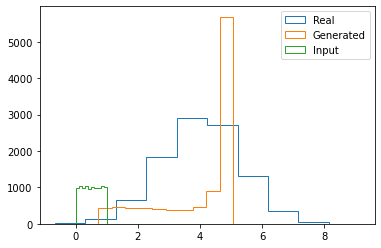

Stage 19 (Epoch: 3800)
Mean and Std of Real: (4.037131995765669, 1.2448713635800517)
Mean and Std of Gen: (4.0063357, 1.2500778)


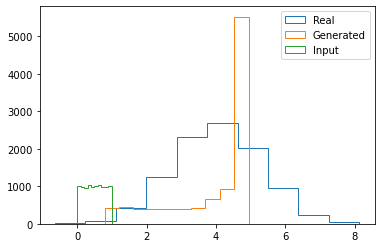

Stage 20 (Epoch: 4000)
Mean and Std of Real: (4.012492570231243, 1.2652809468075064)
Mean and Std of Gen: (4.143028, 1.3021537)


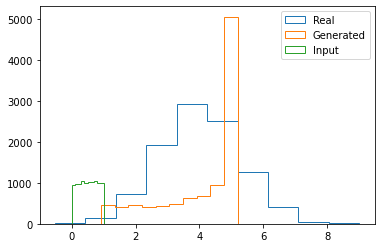

Stage 21 (Epoch: 4200)
Mean and Std of Real: (4.023285833407982, 1.2488702713594044)
Mean and Std of Gen: (3.5452485, 1.2174454)


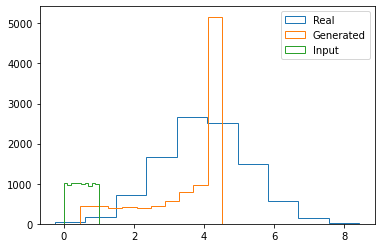

Stage 22 (Epoch: 4400)
Mean and Std of Real: (4.004792494139186, 1.2551942596870587)
Mean and Std of Gen: (3.817064, 1.2641463)


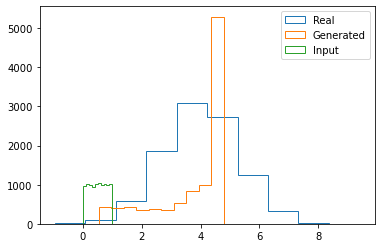

Stage 23 (Epoch: 4600)
Mean and Std of Real: (3.9988889466420607, 1.266481713802311)
Mean and Std of Gen: (4.1540065, 1.1710765)


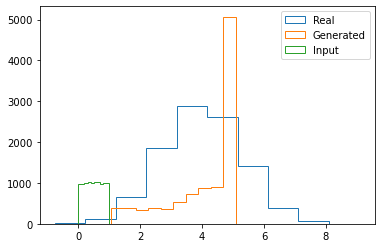

Stage 24 (Epoch: 4800)
Mean and Std of Real: (3.9959683048581844, 1.2446624189402027)
Mean and Std of Gen: (3.6699507, 1.2517153)


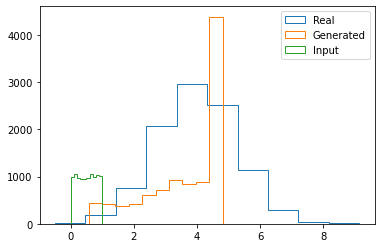

Stage 25 (Epoch: 5000)
Mean and Std of Real: (4.01374836737111, 1.2424495223774112)
Mean and Std of Gen: (4.131925, 1.1709207)


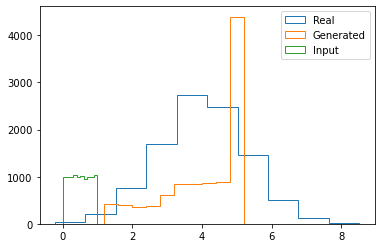

Stage 26 (Epoch: 5200)
Mean and Std of Real: (4.000149219795632, 1.2464816115986672)
Mean and Std of Gen: (3.6546016, 1.1540223)


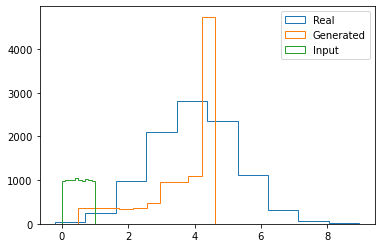

Stage 27 (Epoch: 5400)
Mean and Std of Real: (3.9805019839175415, 1.243337048754587)
Mean and Std of Gen: (3.976279, 1.3096433)


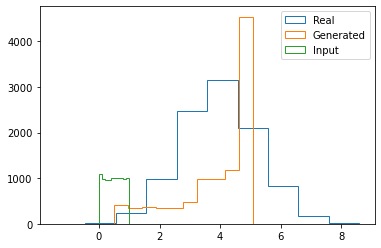

Stage 28 (Epoch: 5600)
Mean and Std of Real: (4.001057322752353, 1.25763942430253)
Mean and Std of Gen: (4.1392074, 1.276975)


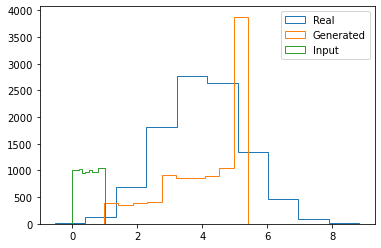

Stage 29 (Epoch: 5800)
Mean and Std of Real: (4.004215909341493, 1.2668955863828195)
Mean and Std of Gen: (4.178629, 1.2733939)


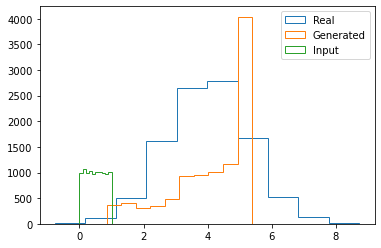

Stage 30 (Epoch: 6000)
Mean and Std of Real: (4.001520179784429, 1.250206669111678)
Mean and Std of Gen: (4.1740456, 1.2342056)


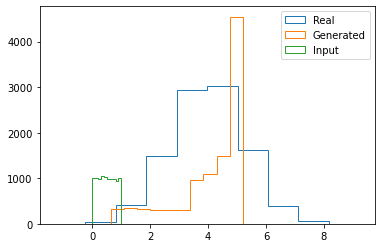

Stage 31 (Epoch: 6200)
Mean and Std of Real: (4.006409377831683, 1.252496972626826)
Mean and Std of Gen: (3.9417734, 1.283416)


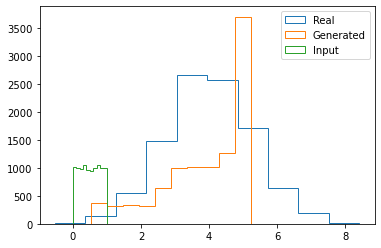

Stage 32 (Epoch: 6400)
Mean and Std of Real: (3.997345920377475, 1.2451690719036401)
Mean and Std of Gen: (4.041946, 1.219428)


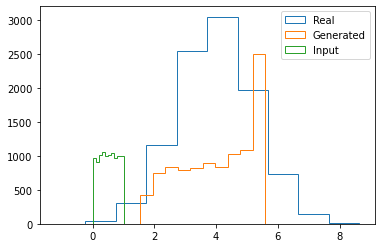

Stage 33 (Epoch: 6600)
Mean and Std of Real: (4.0252920031708035, 1.2541330219859206)
Mean and Std of Gen: (3.6011007, 1.2543391)


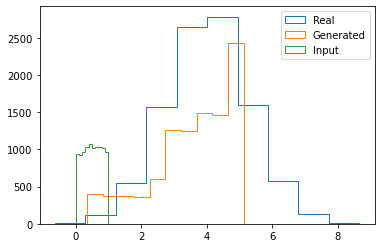

Stage 34 (Epoch: 6800)
Mean and Std of Real: (3.9962002652627167, 1.2436175691737892)
Mean and Std of Gen: (3.598839, 1.3153265)


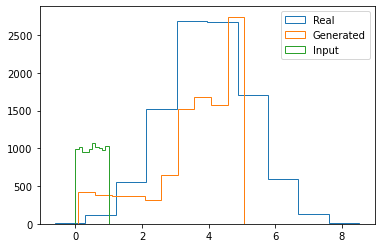

Stage 35 (Epoch: 7000)
Mean and Std of Real: (3.9778649132690496, 1.236171393578888)
Mean and Std of Gen: (4.1373053, 1.1597925)


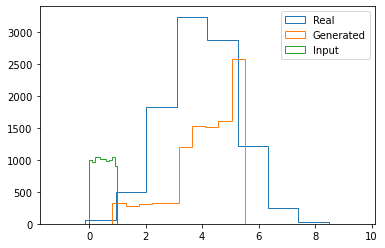

Stage 36 (Epoch: 7200)
Mean and Std of Real: (4.006831671951355, 1.24698621389379)
Mean and Std of Gen: (4.054618, 1.2788516)


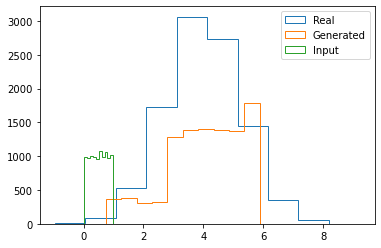

Stage 37 (Epoch: 7400)
Mean and Std of Real: (4.00855274498814, 1.2495768967576582)
Mean and Std of Gen: (3.4473305, 1.4046427)


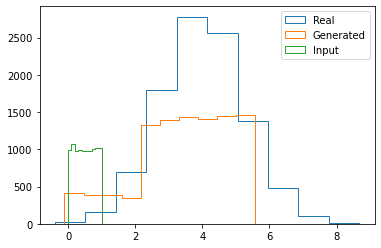

Stage 38 (Epoch: 7600)
Mean and Std of Real: (3.9915100200954563, 1.2412029744697808)
Mean and Std of Gen: (4.5791435, 1.2233351)


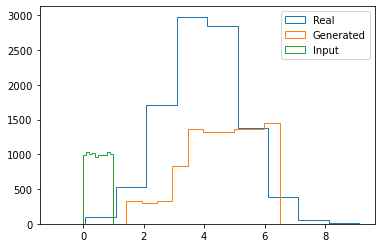

Stage 39 (Epoch: 7800)
Mean and Std of Real: (3.997034140808372, 1.24320777860319)
Mean and Std of Gen: (4.368796, 1.2402512)


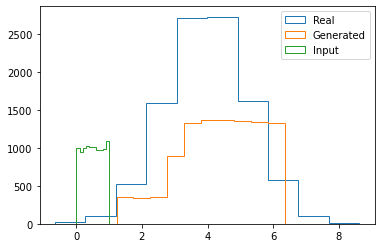

Stage 40 (Epoch: 8000)
Mean and Std of Real: (3.990175412061209, 1.2493067860344964)
Mean and Std of Gen: (3.9978364, 1.2247123)


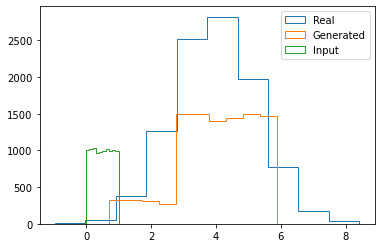

Stage 41 (Epoch: 8200)
Mean and Std of Real: (3.9909673292725376, 1.2526560105122417)
Mean and Std of Gen: (4.129354, 1.2937549)


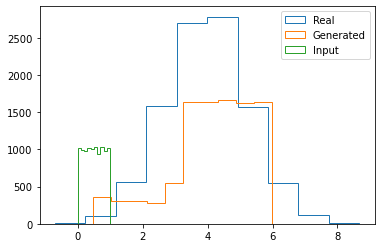

Stage 42 (Epoch: 8400)
Mean and Std of Real: (3.98910610726301, 1.2434814256568083)
Mean and Std of Gen: (3.8456132, 1.2636479)


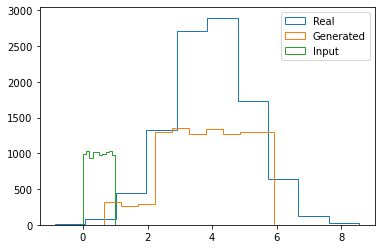

Stage 43 (Epoch: 8600)
Mean and Std of Real: (3.9991333148162274, 1.2613382122105534)
Mean and Std of Gen: (4.067062, 1.2173251)


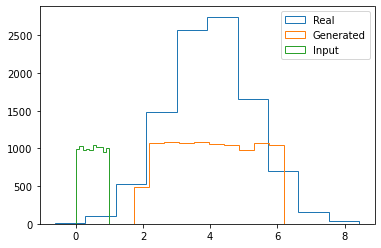

Stage 44 (Epoch: 8800)
Mean and Std of Real: (4.0048813655861215, 1.2468832832679768)
Mean and Std of Gen: (3.4163914, 1.1495786)


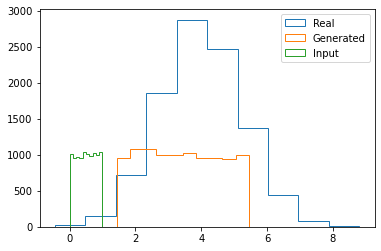

Stage 45 (Epoch: 9000)
Mean and Std of Real: (4.001848986095616, 1.2503476657026842)
Mean and Std of Gen: (3.563146, 1.2515148)


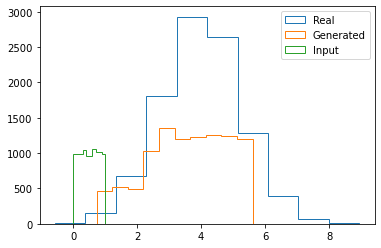

Stage 46 (Epoch: 9200)
Mean and Std of Real: (4.011699021720746, 1.2445792671051337)
Mean and Std of Gen: (3.856048, 1.3670522)


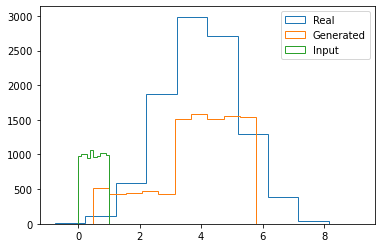

Stage 47 (Epoch: 9400)
Mean and Std of Real: (4.002688663991928, 1.2370157355464464)
Mean and Std of Gen: (4.1856766, 1.2526717)


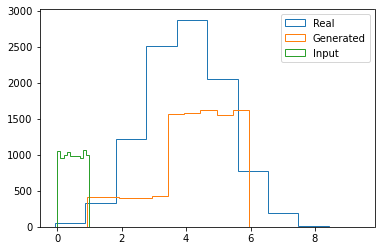

Stage 48 (Epoch: 9600)
Mean and Std of Real: (3.984769949837125, 1.262213309432844)
Mean and Std of Gen: (4.1783166, 1.1937635)


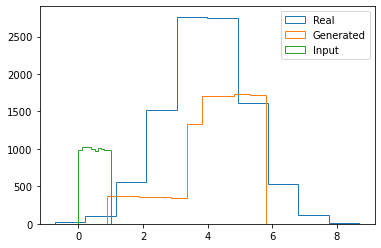

Stage 49 (Epoch: 9800)
Mean and Std of Real: (4.013962664263028, 1.251258387628716)
Mean and Std of Gen: (3.9609296, 1.2135397)


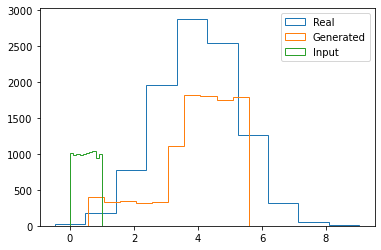

Stage 50 (Epoch: 10000)
Mean and Std of Real: (3.987620927268878, 1.2503409902732763)
Mean and Std of Gen: (4.017632, 1.1718743)


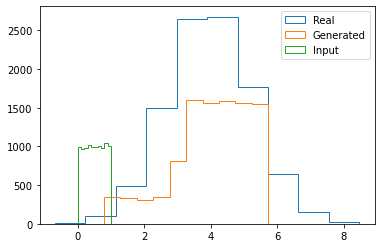

Stage 51 (Epoch: 10200)
Mean and Std of Real: (4.004027202385201, 1.2311859143915926)
Mean and Std of Gen: (4.0223308, 1.2920295)


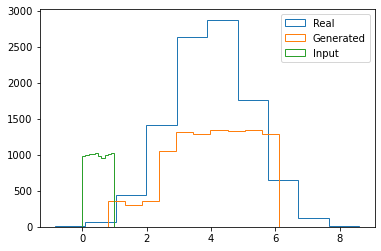

Stage 52 (Epoch: 10400)
Mean and Std of Real: (4.011756981468676, 1.2487504934290776)
Mean and Std of Gen: (4.0875382, 1.2532289)


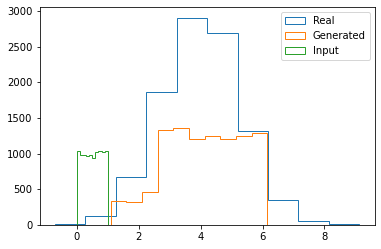

Stage 53 (Epoch: 10600)
Mean and Std of Real: (3.993010259502777, 1.251573763084917)
Mean and Std of Gen: (3.859271, 1.4563012)


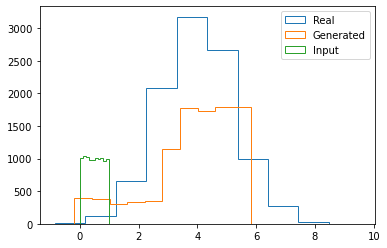

Stage 54 (Epoch: 10800)
Mean and Std of Real: (4.021796957091757, 1.2476275279295563)
Mean and Std of Gen: (4.178753, 1.2488929)


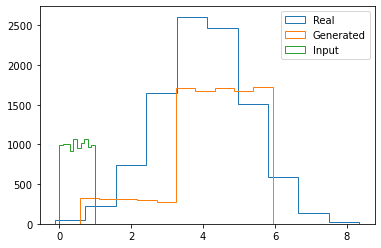

Stage 55 (Epoch: 11000)
Mean and Std of Real: (3.993707224076908, 1.24140860166885)
Mean and Std of Gen: (3.8458922, 1.3576603)


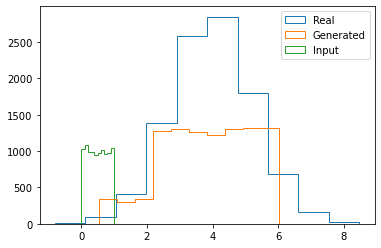

Stage 56 (Epoch: 11200)
Mean and Std of Real: (4.002869020131031, 1.2389614285898136)
Mean and Std of Gen: (4.053907, 1.2304206)


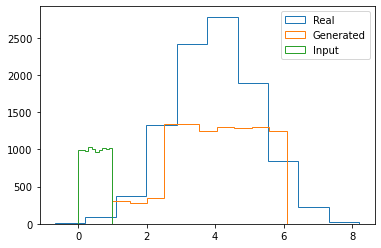

Stage 57 (Epoch: 11400)
Mean and Std of Real: (3.994222777515172, 1.2604377004468204)
Mean and Std of Gen: (3.7601585, 1.2856344)


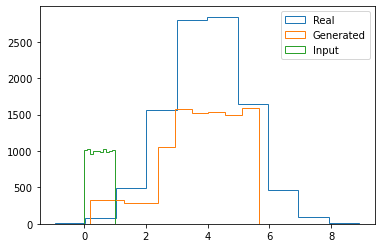

Stage 58 (Epoch: 11600)
Mean and Std of Real: (4.016474845791363, 1.253455301019493)
Mean and Std of Gen: (4.297155, 1.2771825)


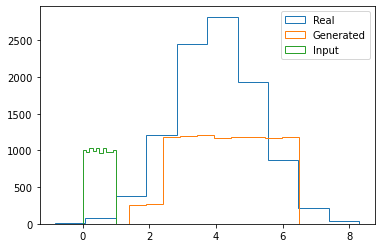

Stage 59 (Epoch: 11800)
Mean and Std of Real: (3.995142582185516, 1.2610981423046967)
Mean and Std of Gen: (4.8245745, 1.2326887)


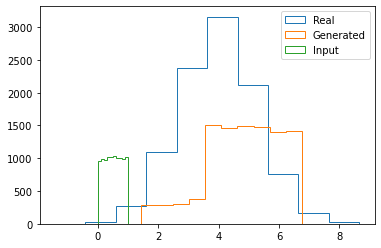

Stage 60 (Epoch: 12000)
Mean and Std of Real: (4.002305459889166, 1.2482023236717823)
Mean and Std of Gen: (4.2119036, 1.2249866)


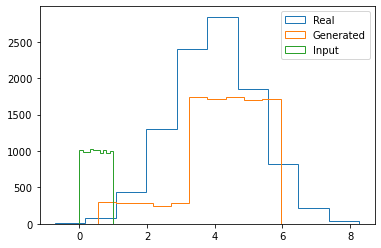

Stage 61 (Epoch: 12200)
Mean and Std of Real: (4.007587963758406, 1.2586581984730663)
Mean and Std of Gen: (4.0638337, 1.1923568)


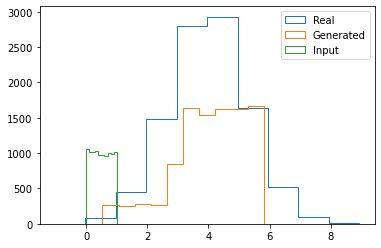

Stage 62 (Epoch: 12400)
Mean and Std of Real: (4.000953647333086, 1.255403336836211)
Mean and Std of Gen: (3.756117, 1.1440053)


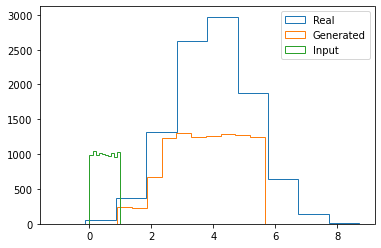

Stage 63 (Epoch: 12600)
Mean and Std of Real: (4.006600701619672, 1.254012999032306)
Mean and Std of Gen: (4.1783013, 1.4152429)


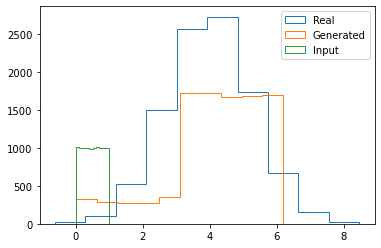

Stage 64 (Epoch: 12800)
Mean and Std of Real: (4.003157497820411, 1.2516869861491813)
Mean and Std of Gen: (4.150223, 1.2338977)


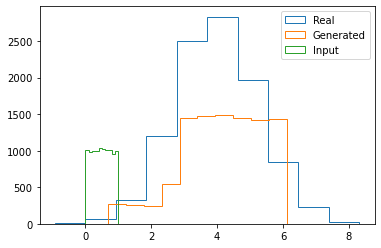

Stage 65 (Epoch: 13000)
Mean and Std of Real: (3.997891482791484, 1.2600160681367294)
Mean and Std of Gen: (3.8628953, 1.2143484)


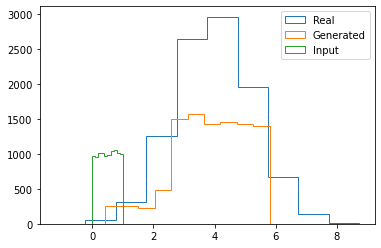

Stage 66 (Epoch: 13200)
Mean and Std of Real: (3.9762191848486013, 1.2479815239886844)
Mean and Std of Gen: (3.7558906, 1.2371628)


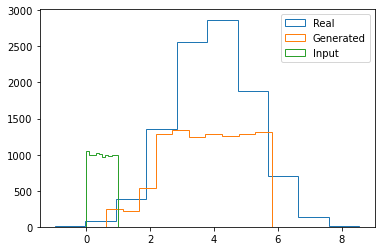

Stage 67 (Epoch: 13400)
Mean and Std of Real: (3.98227685838708, 1.2529835189135219)
Mean and Std of Gen: (4.103965, 1.191419)


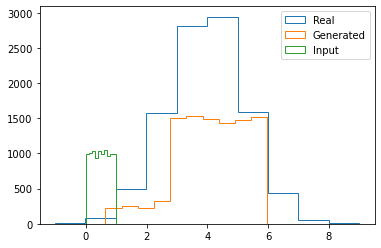

Stage 68 (Epoch: 13600)
Mean and Std of Real: (3.999486340386507, 1.244182958790596)
Mean and Std of Gen: (4.2899623, 1.2170646)


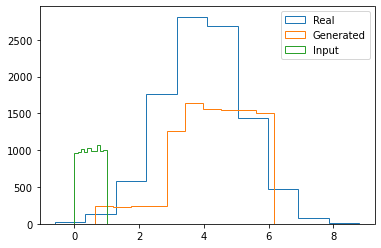

Stage 69 (Epoch: 13800)
Mean and Std of Real: (3.9986531031299157, 1.2659526507416257)
Mean and Std of Gen: (3.7563372, 1.2396055)


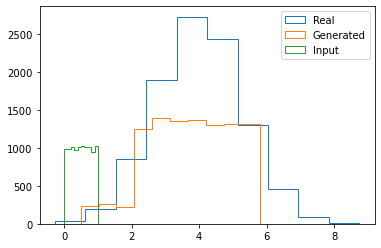

Stage 70 (Epoch: 14000)
Mean and Std of Real: (4.013569118363208, 1.268986495704781)
Mean and Std of Gen: (4.763738, 1.3337157)


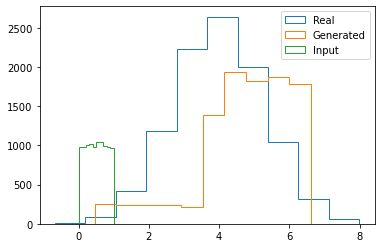

Stage 71 (Epoch: 14200)
Mean and Std of Real: (3.9928894714077354, 1.22340749107262)
Mean and Std of Gen: (3.7015495, 1.1767081)


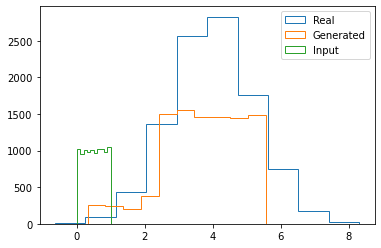

Stage 72 (Epoch: 14400)
Mean and Std of Real: (4.010793347096346, 1.2637852692887248)
Mean and Std of Gen: (3.8833199, 1.1910347)


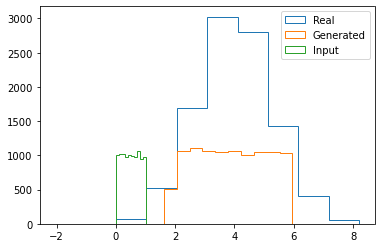

Stage 73 (Epoch: 14600)
Mean and Std of Real: (4.001210406552059, 1.2453495549706557)
Mean and Std of Gen: (3.7151177, 1.267015)


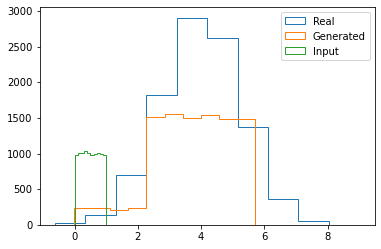

Stage 74 (Epoch: 14800)
Mean and Std of Real: (4.003711381880983, 1.2416661119344545)
Mean and Std of Gen: (4.0956874, 1.2930138)


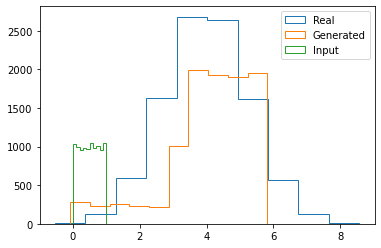

Stage 75 (Epoch: 15000)
Mean and Std of Real: (3.9869209428661794, 1.2692925907278159)
Mean and Std of Gen: (3.9994617, 1.28464)


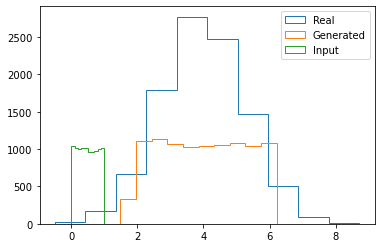

Stage 76 (Epoch: 15200)
Mean and Std of Real: (3.9991728185004396, 1.256125267939284)
Mean and Std of Gen: (4.004103, 1.2294333)


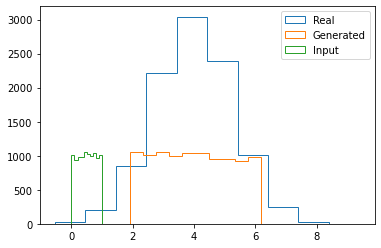

Stage 77 (Epoch: 15400)
Mean and Std of Real: (3.987455501919674, 1.2447043624596348)
Mean and Std of Gen: (3.2766047, 1.1787372)


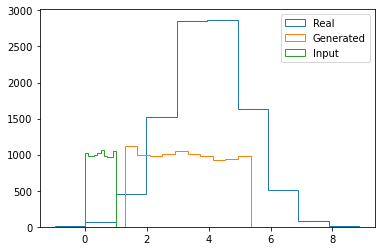

Stage 78 (Epoch: 15600)
Mean and Std of Real: (3.9809120980714825, 1.2528960210977913)
Mean and Std of Gen: (3.3247724, 1.1341743)


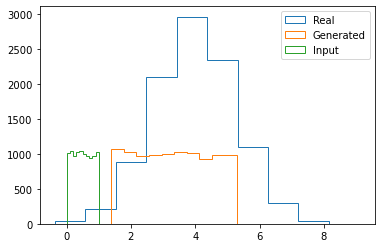

Stage 79 (Epoch: 15800)
Mean and Std of Real: (4.009410587313963, 1.2637200073504773)
Mean and Std of Gen: (3.8401186, 1.1020845)


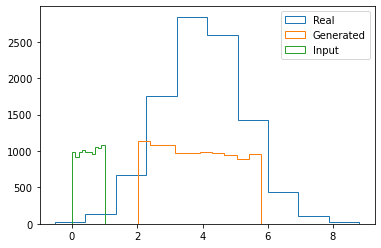

Stage 80 (Epoch: 16000)
Mean and Std of Real: (4.0026651037063825, 1.2523277416360006)
Mean and Std of Gen: (3.3264015, 1.2242646)


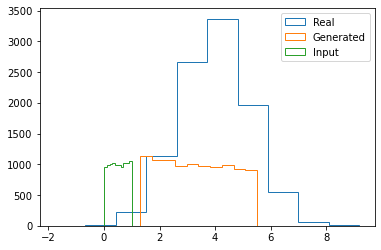

Stage 81 (Epoch: 16200)
Mean and Std of Real: (3.999115207958851, 1.2475557945853744)
Mean and Std of Gen: (3.9100618, 1.169143)


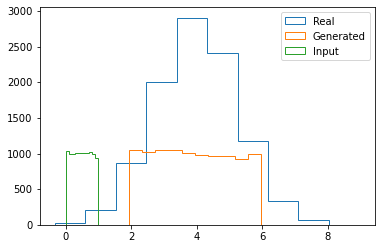

Stage 82 (Epoch: 16400)
Mean and Std of Real: (4.006395590038657, 1.2625811905649003)
Mean and Std of Gen: (3.839043, 1.2079203)


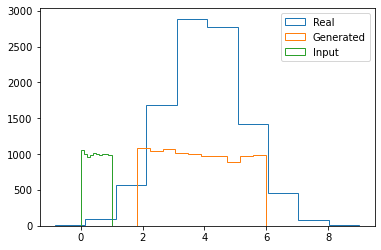

Stage 83 (Epoch: 16600)
Mean and Std of Real: (3.980298366063326, 1.2546289028182602)
Mean and Std of Gen: (3.1290095, 1.2574072)


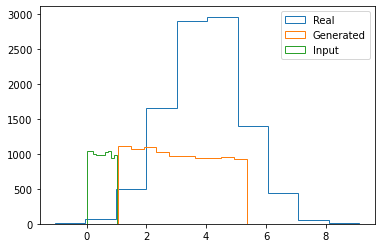

Stage 84 (Epoch: 16800)
Mean and Std of Real: (4.005080297340085, 1.2536113587349524)
Mean and Std of Gen: (4.5963273, 1.025412)


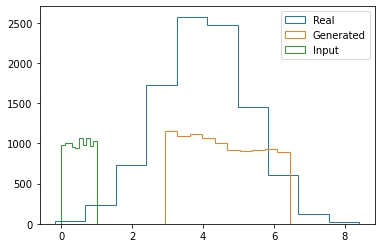

Stage 85 (Epoch: 17000)
Mean and Std of Real: (3.992592617313582, 1.276614166163725)
Mean and Std of Gen: (3.2484703, 1.3020132)


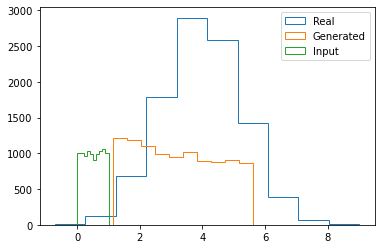

Stage 86 (Epoch: 17200)
Mean and Std of Real: (3.992341604863576, 1.2587167523294691)
Mean and Std of Gen: (3.597212, 1.1247728)


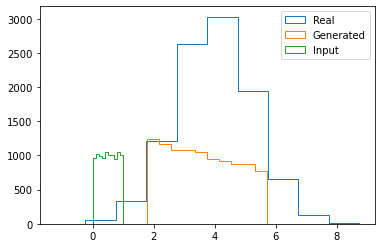

Stage 87 (Epoch: 17400)
Mean and Std of Real: (4.017522115147372, 1.2585349582577163)
Mean and Std of Gen: (3.0882437, 1.3314561)


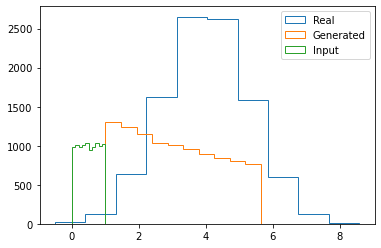

Stage 88 (Epoch: 17600)
Mean and Std of Real: (4.00924111403332, 1.2446276774800022)
Mean and Std of Gen: (4.736387, 0.96406996)


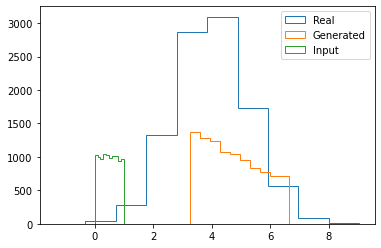

Stage 89 (Epoch: 17800)
Mean and Std of Real: (4.014968606493544, 1.2420253533758274)
Mean and Std of Gen: (3.458173, 1.420165)


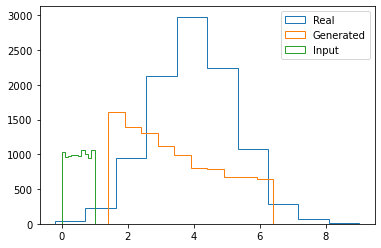

Stage 90 (Epoch: 18000)
Mean and Std of Real: (4.019678269609018, 1.2452080236736307)
Mean and Std of Gen: (4.4757233, 1.2540022)


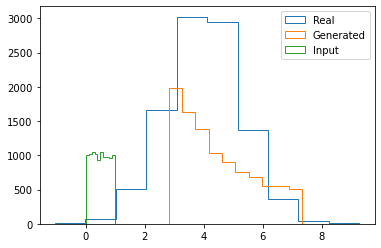

Stage 91 (Epoch: 18200)
Mean and Std of Real: (4.018690940132108, 1.2507822627701497)
Mean and Std of Gen: (4.1983104, 1.2206109)


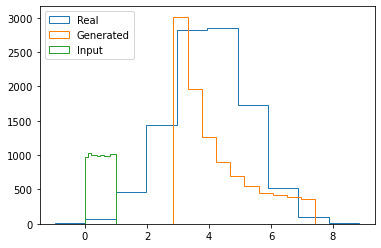

Stage 92 (Epoch: 18400)
Mean and Std of Real: (3.995420786490268, 1.2635349196107737)
Mean and Std of Gen: (4.1972537, 1.3090773)


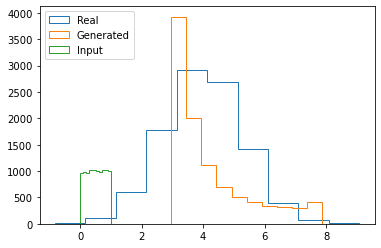

Stage 93 (Epoch: 18600)
Mean and Std of Real: (4.000322754867791, 1.2392899525782775)
Mean and Std of Gen: (5.0462193, 1.4634972)


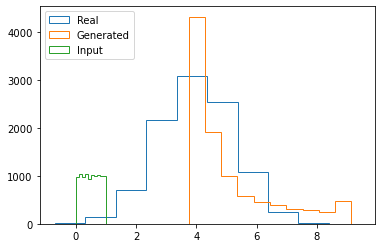

Stage 94 (Epoch: 18800)
Mean and Std of Real: (3.993237092204472, 1.2498074190313015)
Mean and Std of Gen: (5.6828537, 1.3803847)


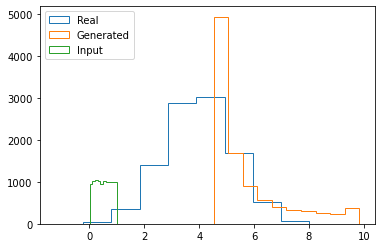

Stage 95 (Epoch: 19000)
Mean and Std of Real: (4.011793933330673, 1.2515128086390404)
Mean and Std of Gen: (5.5792212, 1.4166038)


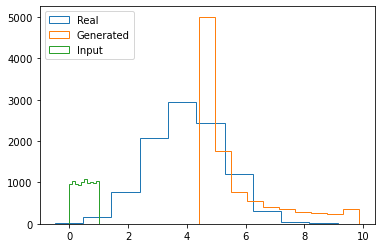

Stage 96 (Epoch: 19200)
Mean and Std of Real: (3.9939068394166455, 1.2692575199187444)
Mean and Std of Gen: (5.278428, 1.415203)


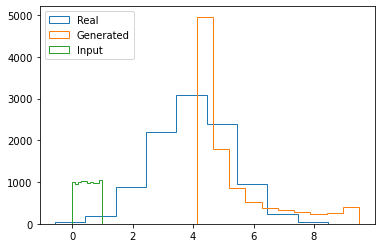

Stage 97 (Epoch: 19400)
Mean and Std of Real: (3.9986413320796115, 1.2465197168716216)
Mean and Std of Gen: (4.8923526, 1.3756357)


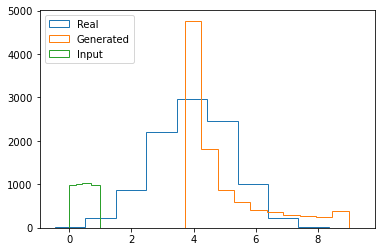

Stage 98 (Epoch: 19600)
Mean and Std of Real: (3.9970851196118327, 1.2353846727879365)
Mean and Std of Gen: (4.783448, 1.3758035)


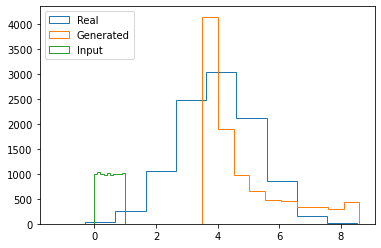

Stage 99 (Epoch: 19800)
Mean and Std of Real: (4.017472495817811, 1.238840936657839)
Mean and Std of Gen: (4.3760357, 1.3487306)


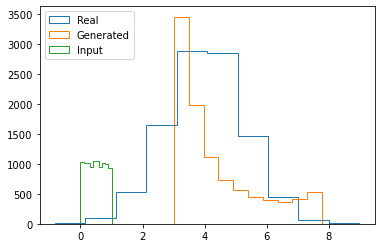

Stage 100 (Epoch: 20000)
Mean and Std of Real: (3.9979329953015315, 1.2298579647846146)
Mean and Std of Gen: (4.337324, 1.2369134)


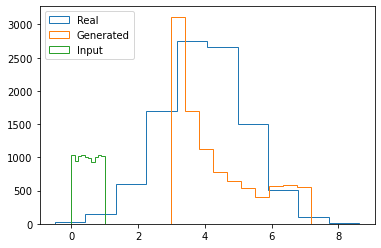

Stage 101 (Epoch: 20200)
Mean and Std of Real: (4.0198490521071575, 1.2437995418699421)
Mean and Std of Gen: (4.1092186, 1.2678607)


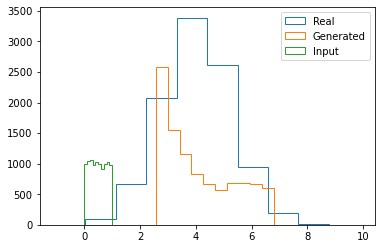

Stage 102 (Epoch: 20400)
Mean and Std of Real: (4.0017754880095175, 1.2573179905873488)
Mean and Std of Gen: (3.9687452, 1.1858208)


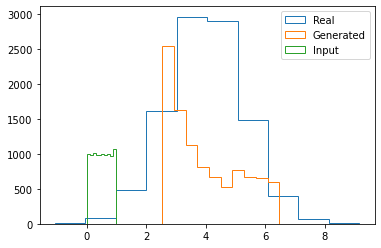

Stage 103 (Epoch: 20600)
Mean and Std of Real: (4.000012772903509, 1.2482563279469556)
Mean and Std of Gen: (3.0960693, 1.3789028)


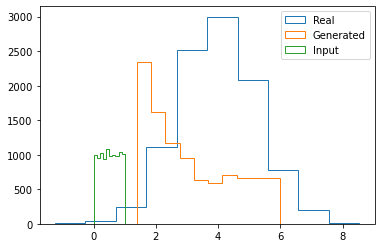

Stage 104 (Epoch: 20800)
Mean and Std of Real: (4.0129488094229995, 1.266152995481908)
Mean and Std of Gen: (4.2846155, 1.1264135)


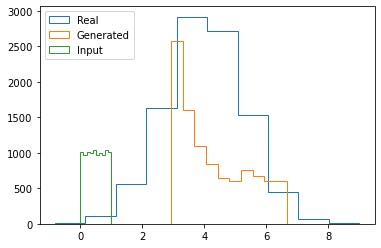

Stage 105 (Epoch: 21000)
Mean and Std of Real: (4.013318144831822, 1.2433732006690736)
Mean and Std of Gen: (3.327684, 1.3698198)


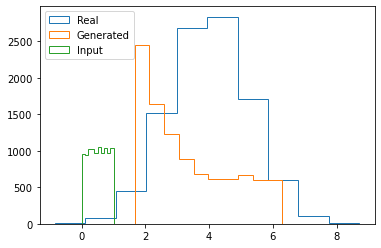

Stage 106 (Epoch: 21200)
Mean and Std of Real: (3.9784132787654065, 1.2562784193666579)
Mean and Std of Gen: (4.3329096, 1.1646953)


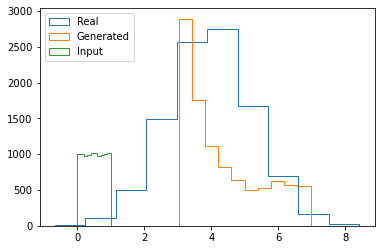

Stage 107 (Epoch: 21400)
Mean and Std of Real: (4.002112663924854, 1.2313548672257997)
Mean and Std of Gen: (3.7496874, 1.2663741)


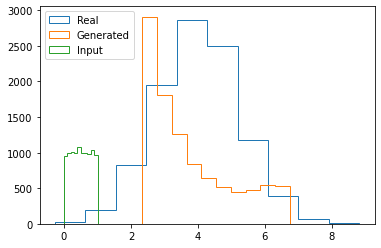

Stage 108 (Epoch: 21600)
Mean and Std of Real: (3.978826956335495, 1.236323461109991)
Mean and Std of Gen: (3.6517746, 1.2787695)


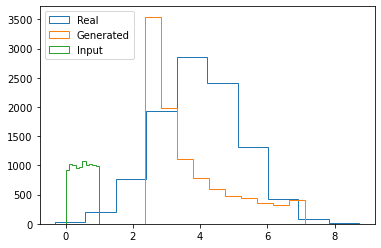

Stage 109 (Epoch: 21800)
Mean and Std of Real: (3.9835192885296107, 1.2521869751630845)
Mean and Std of Gen: (4.1613593, 1.1806804)


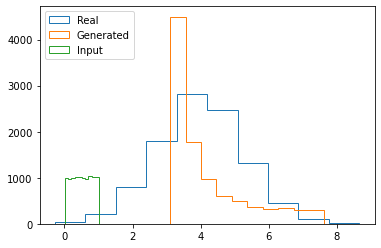

Stage 110 (Epoch: 22000)
Mean and Std of Real: (4.012970079950019, 1.254909038657338)
Mean and Std of Gen: (4.258731, 1.2186874)


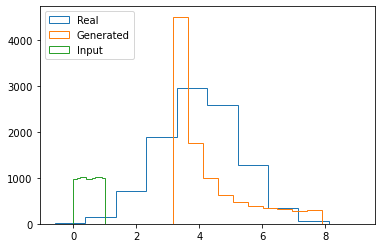

Stage 111 (Epoch: 22200)
Mean and Std of Real: (4.010192186004433, 1.240750446832349)
Mean and Std of Gen: (4.0924535, 1.1750015)


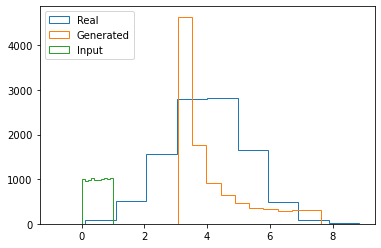

Stage 112 (Epoch: 22400)
Mean and Std of Real: (4.008529329751953, 1.2451518012426572)
Mean and Std of Gen: (3.8759632, 1.3591628)


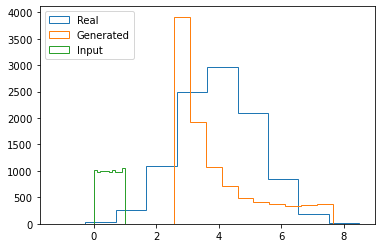

Stage 113 (Epoch: 22600)
Mean and Std of Real: (3.9810993421279925, 1.232287450416381)
Mean and Std of Gen: (4.2788134, 1.2068585)


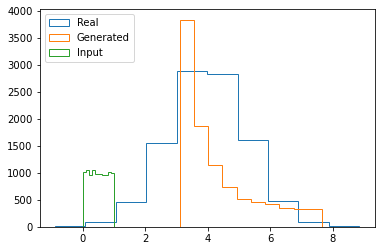

Stage 114 (Epoch: 22800)
Mean and Std of Real: (3.995089440007256, 1.2484146208990636)
Mean and Std of Gen: (4.046334, 1.2313923)


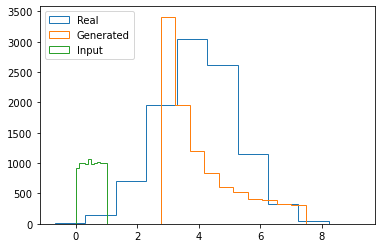

Stage 115 (Epoch: 23000)
Mean and Std of Real: (3.9802984389807863, 1.2378550926137226)
Mean and Std of Gen: (4.1329274, 1.273889)


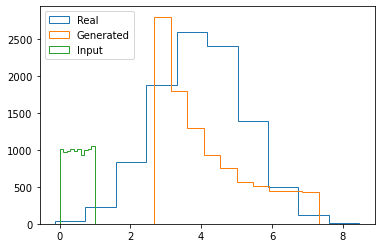

Stage 116 (Epoch: 23200)
Mean and Std of Real: (4.007420528012155, 1.25336249845175)
Mean and Std of Gen: (3.9773886, 1.285806)


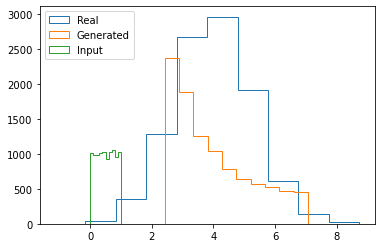

Stage 117 (Epoch: 23400)
Mean and Std of Real: (4.005794449094617, 1.2355388540716519)
Mean and Std of Gen: (3.5440664, 1.2755572)


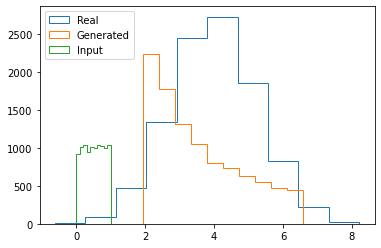

Stage 118 (Epoch: 23600)
Mean and Std of Real: (4.000381298522509, 1.2418333514599627)
Mean and Std of Gen: (4.000833, 0.99227995)


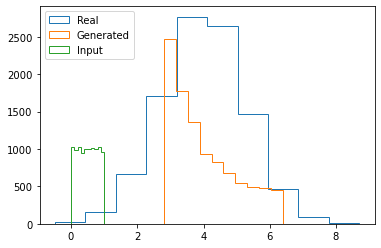

Stage 119 (Epoch: 23800)
Mean and Std of Real: (4.003703331673313, 1.257789307778123)
Mean and Std of Gen: (4.3134246, 1.2938756)


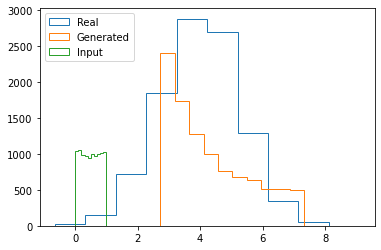

Stage 120 (Epoch: 24000)
Mean and Std of Real: (3.997853578956508, 1.2613314311900545)
Mean and Std of Gen: (4.0444455, 1.287263)


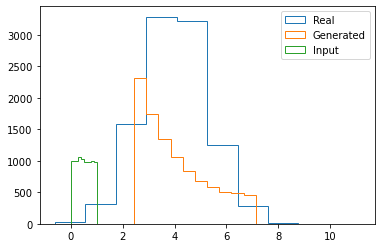

Stage 121 (Epoch: 24200)
Mean and Std of Real: (3.9886713192874477, 1.2537463154366122)
Mean and Std of Gen: (4.234295, 1.2778533)


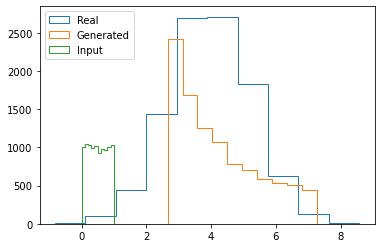

Stage 122 (Epoch: 24400)
Mean and Std of Real: (4.00155276321519, 1.261679610576724)
Mean and Std of Gen: (4.3960447, 1.0391698)


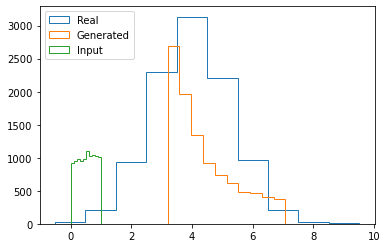

Stage 123 (Epoch: 24600)
Mean and Std of Real: (3.9982326089703997, 1.2496504208797254)
Mean and Std of Gen: (3.6885777, 1.4132137)


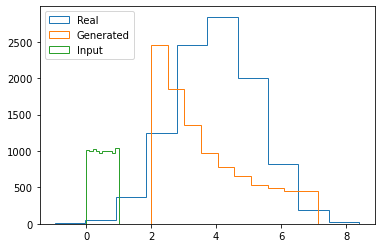

Stage 124 (Epoch: 24800)
Mean and Std of Real: (4.0294207208365735, 1.245397435008722)
Mean and Std of Gen: (4.285003, 1.2125374)


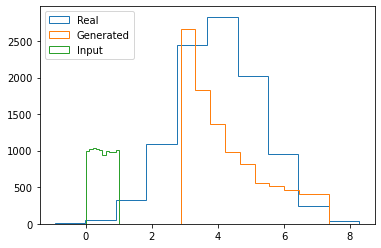

Stage 125 (Epoch: 25000)
Mean and Std of Real: (4.006391705317507, 1.2403171607870604)
Mean and Std of Gen: (3.8898337, 1.3211874)


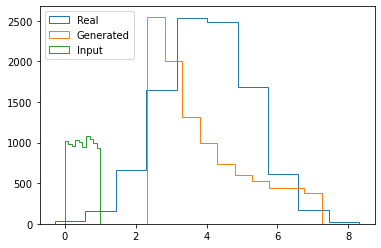

Stage 126 (Epoch: 25200)
Mean and Std of Real: (3.986981866527664, 1.2469904160770966)
Mean and Std of Gen: (3.5369792, 1.391047)


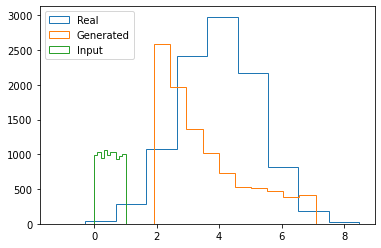

Stage 127 (Epoch: 25400)
Mean and Std of Real: (3.9955684715040465, 1.2518049769199335)
Mean and Std of Gen: (4.3789907, 1.078785)


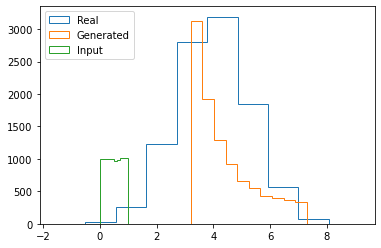

Stage 128 (Epoch: 25600)
Mean and Std of Real: (3.9948266115342705, 1.2575480244828883)
Mean and Std of Gen: (3.8906567, 1.2446903)


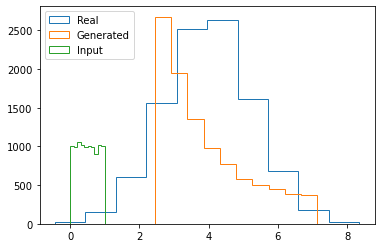

Stage 129 (Epoch: 25800)
Mean and Std of Real: (3.997928316114829, 1.2472925036851368)
Mean and Std of Gen: (3.8108737, 1.237432)


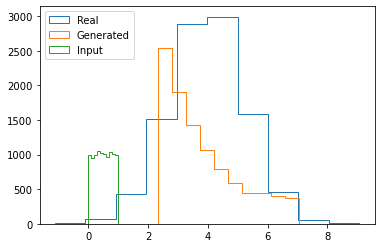

Stage 130 (Epoch: 26000)
Mean and Std of Real: (4.02051511302155, 1.2409309249453058)
Mean and Std of Gen: (3.7900648, 1.3174119)


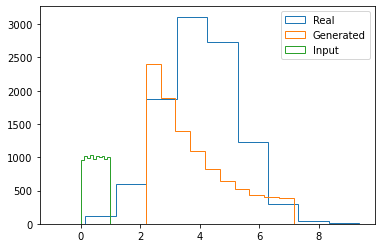

Stage 131 (Epoch: 26200)
Mean and Std of Real: (4.014801101561144, 1.2468387998946422)
Mean and Std of Gen: (4.1347327, 1.159019)


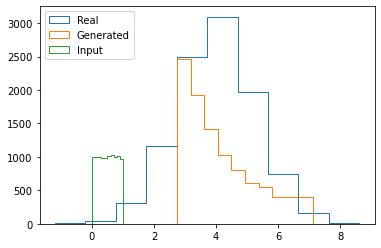

Stage 132 (Epoch: 26400)
Mean and Std of Real: (3.9986577551123816, 1.2556865772876336)
Mean and Std of Gen: (3.7284696, 1.2823175)


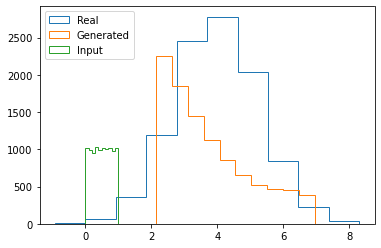

Stage 133 (Epoch: 26600)
Mean and Std of Real: (4.000820932687373, 1.245872243662514)
Mean and Std of Gen: (4.343462, 1.3237841)


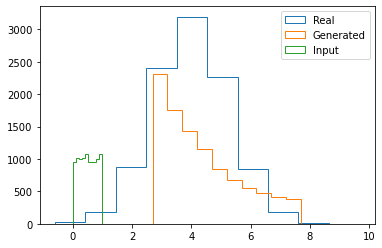

Stage 134 (Epoch: 26800)
Mean and Std of Real: (4.001534974894354, 1.2536267367757201)
Mean and Std of Gen: (3.7154093, 1.2861891)


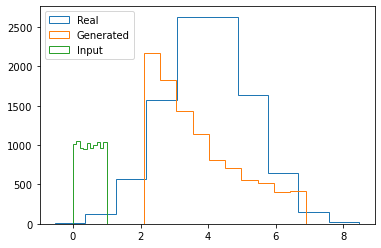

Stage 135 (Epoch: 27000)
Mean and Std of Real: (3.997003328005541, 1.2435867487011256)
Mean and Std of Gen: (3.8462434, 1.2269442)


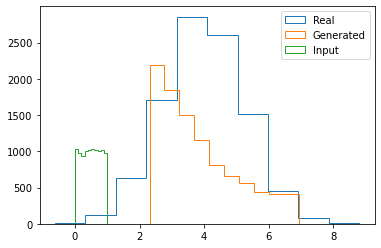

Stage 136 (Epoch: 27200)
Mean and Std of Real: (4.013381015345578, 1.247377526620734)
Mean and Std of Gen: (4.1896725, 1.3001087)


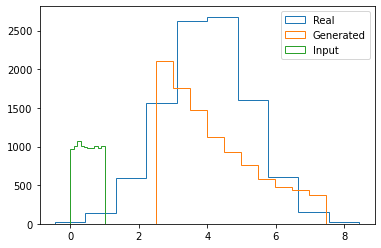

Stage 137 (Epoch: 27400)
Mean and Std of Real: (4.012672149966288, 1.2580323501284945)
Mean and Std of Gen: (4.3631434, 1.2169495)


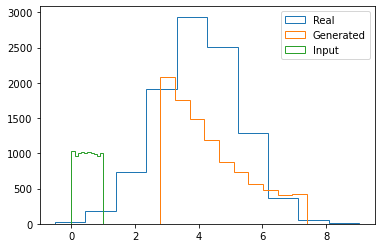

Stage 138 (Epoch: 27600)
Mean and Std of Real: (4.024621497757563, 1.2521452570305986)
Mean and Std of Gen: (3.712539, 1.3424188)


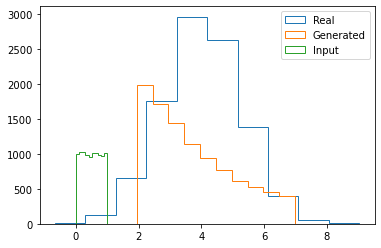

Stage 139 (Epoch: 27800)
Mean and Std of Real: (4.011059330116528, 1.260509533497733)
Mean and Std of Gen: (4.0089602, 1.201354)


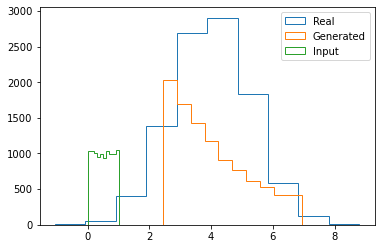

Stage 140 (Epoch: 28000)
Mean and Std of Real: (4.012249212825767, 1.2482730302447778)
Mean and Std of Gen: (4.02376, 1.4173872)


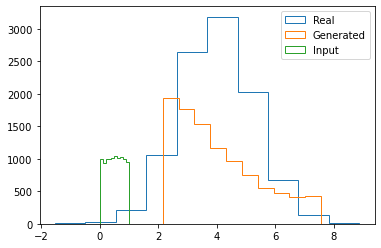

Stage 141 (Epoch: 28200)
Mean and Std of Real: (3.970059094252259, 1.2475520857741873)
Mean and Std of Gen: (3.8828313, 1.3062584)


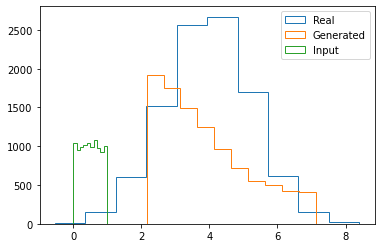

Stage 142 (Epoch: 28400)
Mean and Std of Real: (3.9898138174212443, 1.2522838873719186)
Mean and Std of Gen: (3.637403, 1.3344233)


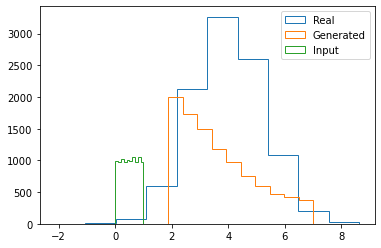

Stage 143 (Epoch: 28600)
Mean and Std of Real: (4.014596310929197, 1.255302815976549)
Mean and Std of Gen: (3.1805756, 1.3886093)


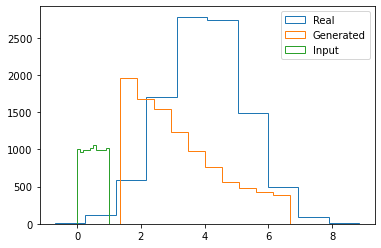

Stage 144 (Epoch: 28800)
Mean and Std of Real: (4.023825988925042, 1.2679387753151294)
Mean and Std of Gen: (3.3713589, 1.4113189)


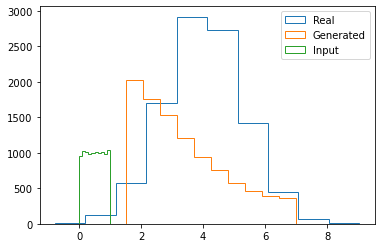

Stage 145 (Epoch: 29000)
Mean and Std of Real: (3.987277481129008, 1.253058202644787)
Mean and Std of Gen: (4.1629963, 1.0704187)


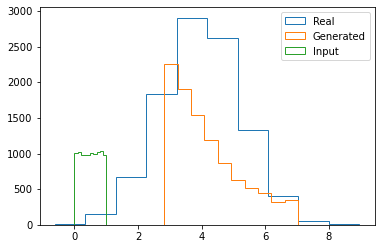

Stage 146 (Epoch: 29200)
Mean and Std of Real: (4.0001596104307655, 1.2477431042866653)
Mean and Std of Gen: (4.129863, 1.273213)


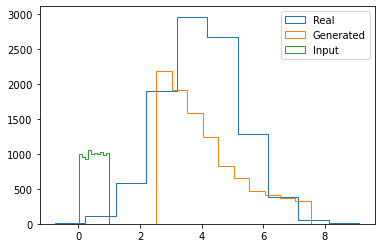

Stage 147 (Epoch: 29400)
Mean and Std of Real: (4.006600268441562, 1.242850491583109)
Mean and Std of Gen: (4.447808, 1.1693708)


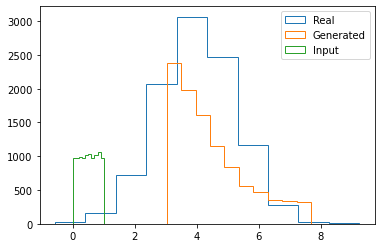

Stage 148 (Epoch: 29600)
Mean and Std of Real: (4.001660393057665, 1.2520126685566075)
Mean and Std of Gen: (3.6887476, 1.3677677)


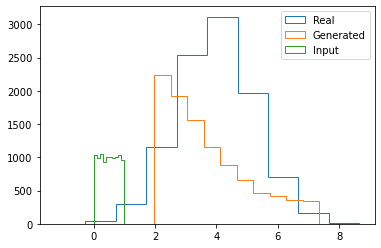

Stage 149 (Epoch: 29800)
Mean and Std of Real: (3.984427417649638, 1.2382154604151447)
Mean and Std of Gen: (3.9886172, 1.2128725)


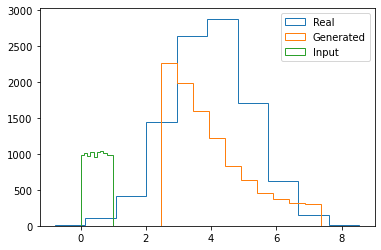

Stage 150 (Epoch: 30000)
Mean and Std of Real: (3.997184258442375, 1.2626299404946482)
Mean and Std of Gen: (4.2380214, 1.3013004)


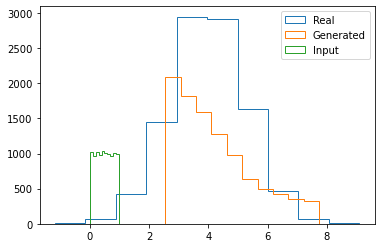

Stage 151 (Epoch: 30200)
Mean and Std of Real: (3.996098714491109, 1.2525095746215575)
Mean and Std of Gen: (4.132353, 1.1822116)


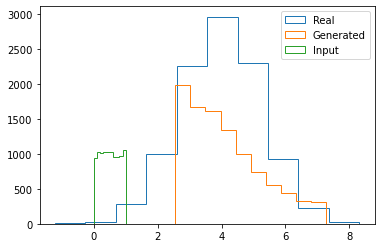

Stage 152 (Epoch: 30400)
Mean and Std of Real: (4.0084950008254605, 1.2581763260769707)
Mean and Std of Gen: (4.4333873, 1.1862519)


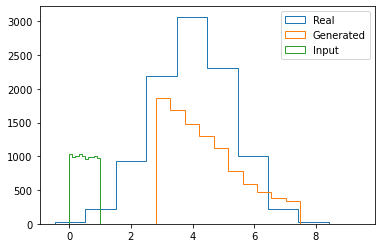

Stage 153 (Epoch: 30600)
Mean and Std of Real: (4.0036655800926235, 1.2377178415013457)
Mean and Std of Gen: (3.855036, 1.2156985)


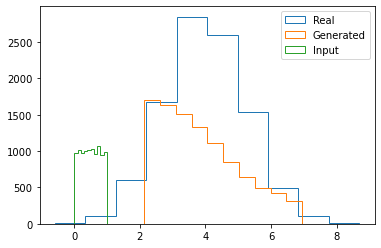

Stage 154 (Epoch: 30800)
Mean and Std of Real: (3.9953338499949815, 1.2362627516686189)
Mean and Std of Gen: (4.3096123, 1.1179004)


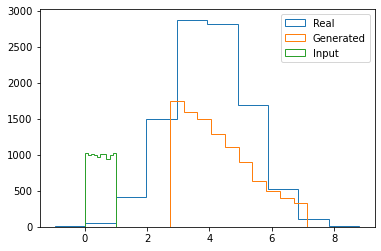

Stage 155 (Epoch: 31000)
Mean and Std of Real: (3.997898109144537, 1.2399368835542315)
Mean and Std of Gen: (4.1775985, 1.2843378)


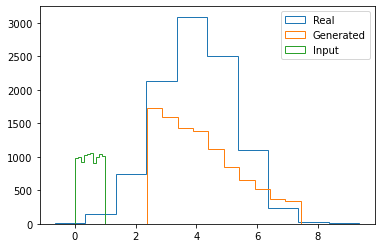

Stage 156 (Epoch: 31200)
Mean and Std of Real: (3.984033258563276, 1.2623027424809288)
Mean and Std of Gen: (4.039766, 1.350877)


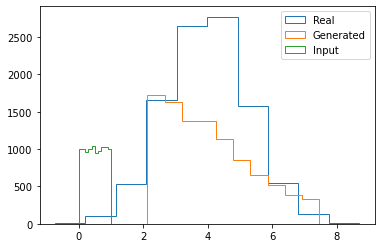

Stage 157 (Epoch: 31400)
Mean and Std of Real: (4.002454287394324, 1.2329845925641794)
Mean and Std of Gen: (4.3406615, 1.2015488)


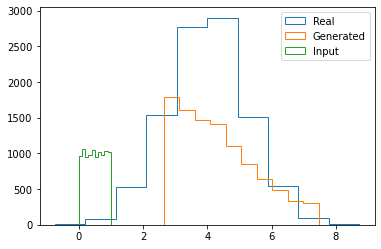

Stage 158 (Epoch: 31600)


In [ ]:
machine = Machine(n_batch=1, ni_D=100)
machine.run(n_repeat=200, n_show=200, n_test=100)